In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [11]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd. read_csv('nlp-getting-started/test.csv')
sample_submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape = {df_test.shape}')
print(df_train.columns)
count_ones = (df_train['target'] == 1).sum()
count_zeros = (df_train['target'] == 0).sum()
print("Count of ones:", count_ones)
print("Count of zeros:", count_zeros)
df_train.info()
print(df_train.duplicated().value_counts())
print(df_test.duplicated().value_counts())

df_train.shape = (7613, 5)
df_test.shape = (3263, 4)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Count of ones: 3271
Count of zeros: 4342
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
False    7613
Name: count, dtype: int64
False    3263
Name: count, dtype: int64


In [18]:
train_data, test_data = train_test_split(df_train, test_size = 0.2, random_state = 0)

In [19]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words,oov_token = '<OOV>')
tokenizer.fit_on_texts(df_train["text"])
max_len = 200
train_sequences = tokenizer.texts_to_sequences(train_data["text"])
train_padded = pad_sequences(train_sequences, maxlen = max_len, padding = "post", truncating = "post")
test_sequences = tokenizer.texts_to_sequences(test_data["text"])
test_padded = pad_sequences(test_sequences, maxlen = max_len, padding = "post", truncating = "post")


In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())  # Flatten layer to 2D
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
custom_lr = 0.00003
custom_optimizer = Adam(learning_rate=custom_lr)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(train_padded, 
                    train_data['target'], 
                    epochs = 100, 
                    batch_size=256, 
                    validation_data=(test_padded, test_data['target']), 
                    callbacks=[early_stopping])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5345 - loss: 0.6908 - val_accuracy: 0.5817 - val_loss: 0.6800
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5695 - loss: 0.6828 - val_accuracy: 0.5817 - val_loss: 0.6788
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5602 - loss: 0.6849 - val_accuracy: 0.5817 - val_loss: 0.6777
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5676 - loss: 0.6814 - val_accuracy: 0.5817 - val_loss: 0.6750
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 940ms/step - accuracy: 0.5671 - loss: 0.6789 - val_accuracy: 0.5817 - val_loss: 0.6692
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5578 - loss: 0.6758 - val_accuracy: 0.5817 - val_loss: 0.6578
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5895 - loss: 0.6617 - val_accuracy: 0.6001 - val_loss: 0.6369
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6443 - loss: 0.6354 - val_accuracy: 0.7137 

In [30]:
model.save_weights('nlp_model.weights.h5')
with open('nlp_model_architecture.json', 'w') as f:
    f.write(model.to_json())
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


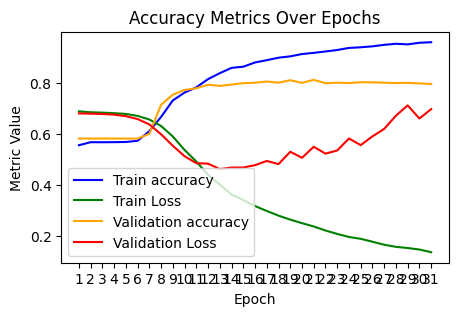

In [36]:
accuracy = pd.DataFrame()
accuracy['loss'] = history.history['loss']
accuracy['accuracy'] = history.history['accuracy']
accuracy['val_loss'] = history.history['val_loss']
accuracy['val_accuracy'] = history.history['val_accuracy']
accuracy.to_csv('nlp_accuracy.csv', index = False)

fig, ax = plt.subplots(figsize=(5, 3))

# Plot the accuracy metrics against the epoch
ax.plot(accuracy.index + 1, accuracy['accuracy'], label='Train accuracy', color='blue')
ax.plot(accuracy.index + 1, accuracy['loss'], label='Train Loss', color='green')
ax.plot(accuracy.index + 1, accuracy['val_accuracy'], label='Validation accuracy', color='orange')
ax.plot(accuracy.index + 1, accuracy['val_loss'], label='Validation Loss', color='red')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.set_title('Accuracy Metrics Over Epochs')
plt.xticks(range(1, len(accuracy) + 1))
# Add legend
ax.legend()

# Show plot
plt.show()

In [33]:
y_pred = model.predict(test_padded)
y_pred = (y_pred > 0.5).astype(int)

# Calculate F1-score
f1 = f1_score(test_data['target'], y_pred)
print(f"F1 Score: {f1}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
F1 Score: 0.7534246575342466


In [34]:
test_sequences = tokenizer.texts_to_sequences(df_test["text"])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

# Make predictions on the test data
predictions = model.predict(test_padded)
# Convert probabilities to binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Create a new column 'predicted_target' in the test DataFrame
df_test['target'] = binary_predictions

# Display the DataFrame with predicted targets
print(df_test[['id', 'text', 'target']])

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
         id                                               text  target
0         0                 Just happened a terrible car crash       1
1         2  Heard about #earthquake is different cities, s...       0
2         3  there is a forest fire at spot pond, geese are...       1
3         9           Apocalypse lighting. #Spokane #wildfires       0
4        11      Typhoon Soudelor kills 28 in China and Taiwan       1
...     ...                                                ...     ...
3258  10861  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...       0
3259  10865  Storm in RI worse than last hurricane. My city...       1
3260  10868  Green Line derailment in Chicago http://t.co/U...       1
3261  10874  MEG issues Hazardous Weather Outlook (HWO) htt...       1
3262  10875  #CityofCalgary has activated its Municipal Eme...       1

[3263 rows x 3 columns]


In [35]:
df_final = df_test[['id', 'target']]
print(df_final.info())
df_final.to_csv('nlp_submission.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int32
dtypes: int32(1), int64(1)
memory usage: 38.4 KB
None
